Using XFOIL: /home/markus/PyCharmMiscProject/aero-surrogate/.venv/bin/xfoil
10/750 done | ok=7 | last file=naca6421_Re16000000_M0.70_a-4to20_da0.50.txt
20/750 done | ok=12 | last file=naca2218_Re16000000_M0.20_a-4to20_da0.50.txt
30/750 done | ok=18 | last file=naca6009_Re32000000_M0.10_a-4to20_da0.50.txt
40/750 done | ok=26 | last file=naca306_Re4000000_M0.85_a-4to20_da0.50.txt
50/750 done | ok=34 | last file=naca612_Re32000000_M0.10_a-4to20_da0.50.txt
60/750 done | ok=42 | last file=naca4612_Re2000000_M0.10_a-4to20_da0.50.txt
70/750 done | ok=49 | last file=naca2721_Re2000000_M0.20_a-4to20_da0.50.txt
80/750 done | ok=55 | last file=naca6009_Re2000000_M0.30_a-4to20_da0.50.txt
90/750 done | ok=64 | last file=naca4321_Re8000000_M0.30_a-4to20_da0.50.txt
100/750 done | ok=73 | last file=naca2012_Re64000000_M0.40_a-4to20_da0.50.txt
110/750 done | ok=79 | last file=naca415_Re8000000_M0.60_a-4to20_da0.50.txt
120/750 done | ok=87 | last file=naca6518_Re16000000_M0.60_a-4to20_da0.50.txt
130/750

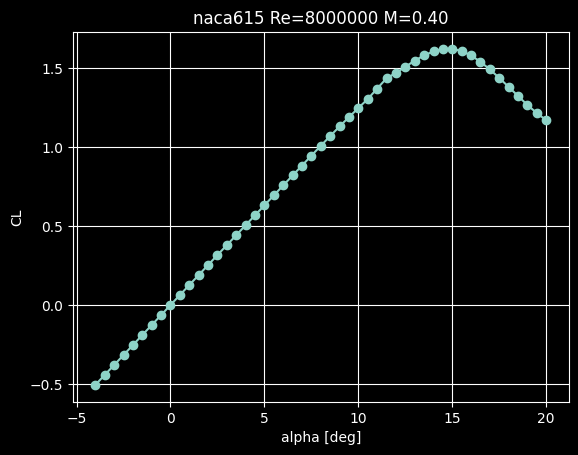

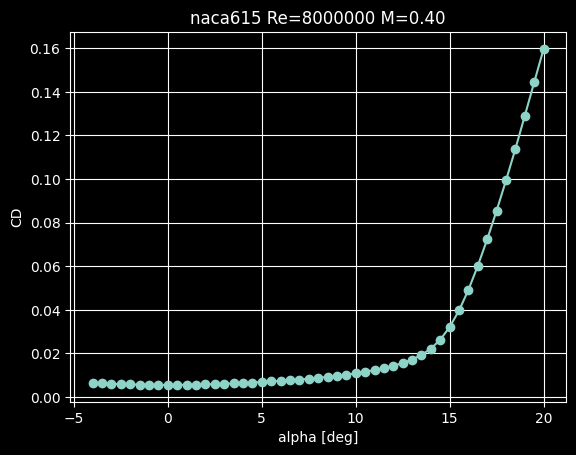

In [1]:
from pathlib import Path
import subprocess
import numpy as np
import pandas as pd
import sys
import platform
from shutil import which

# -----------------------------
# Project root (assumes notebook is in /notebooks)
# -----------------------------
ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from src.io_xfoil import parse_xfoil_polar_txt  # noqa


# -----------------------------
# Auto-find XFOIL (no manual path needed)
# -----------------------------
def find_xfoil_exe(project_root: Path) -> Path:
    """
    Try to find xfoil.exe automatically on Windows.
    Search order:
      1) <repo>/tools/xfoil/xfoil.exe
      2) PATH (shutil.which)
      3) common locations (Downloads/Desktop/Documents, C:/XFOIL*, Program Files)
    """
    if platform.system() == "Linux":
        # Linux Pfad, Markus PC
        return Path("/home/markus/PyCharmMiscProject/aero-surrogate/.venv/bin/xfoil") #xfoil muss ggf. ausführbar gemacht worden sein

    # 1) Repo-local (best for teams)
    candidate = project_root / "tools" / "xfoil" / "xfoil.exe"
    if candidate.exists():
        return candidate

    # 2) PATH
    p = which("xfoil") or which("xfoil.exe")
    if p:
        return Path(p)

    # 3) Common locations (quick search)
    home = Path.home()
    common_roots = [
        home / "Downloads",
        home / "Desktop",
        home / "Documents",
        Path("C:/XFOIL"),
        Path("C:/XFOIL6.99"),
        Path("C:/Program Files"),
        Path("C:/Program Files (x86)"),
    ]

    patterns = [
        "**/xfoil.exe",
        "**/XFOIL*/xfoil.exe",
        "**/xfoil*/xfoil.exe",
    ]

    for root in common_roots:
        if root.exists():
            for pat in patterns:
                hits = list(root.glob(pat))
                if hits:
                    return hits[0]

    raise FileNotFoundError(
        "Konnte xfoil.exe nicht automatisch finden.\n"
        "Option A (empfohlen fürs Team): Lege xfoil.exe in <repo>/tools/xfoil/xfoil.exe\n"
        "Option B: Installiere XFOIL und füge den Ordner mit xfoil.exe zur PATH-Umgebungsvariable hinzu."
    )


XFOIL_EXE = find_xfoil_exe(ROOT)
print("Using XFOIL:", XFOIL_EXE)

# -----------------------------
# Output dirs
# -----------------------------
RAW_DIR = ROOT / "data" / "raw" / "polars"
RAW_DIR.mkdir(parents=True, exist_ok=True)

PROCESSED_DIR = ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


# -----------------------------
# XFOIL runner with timeout (prevents hanging forever)
# -----------------------------
def run_xfoil_polar(
    naca_in: int,
    re_in: float,
    mach_in: float,
    alpha_start: float,
    alpha_end: float,
    alpha_step: float,
    polar_path: Path,
    iters: int = 250,
    timeout_sec: int = 25,
    retries: int = 1,
) -> tuple[bool, str]:
    """
    Runs XFOIL in batch mode and writes polar_path.
    If XFOIL hangs, timeout stops it. Optionally retries a small number of times.
    Returns (ok, log_text).
    """
    polar_path.parent.mkdir(parents=True, exist_ok=True)
    polar_rel = polar_path.relative_to(ROOT).as_posix()

    script = f"""\
NACA {naca_in}
PANE
OPER
ITER {iters}
VISC {re_in:.0f}
MACH {mach_in:.3f}
PACC
{polar_rel}

ASEQ {alpha_start:.3f} {alpha_end:.3f} {alpha_step:.3f}
PACC
QUIT
"""

    last_log = ""
    for attempt in range(retries + 1):
        try:
            res = subprocess.run(
            [str(XFOIL_EXE)],
            input=script,
            text=True,
            cwd=str(ROOT),
            capture_output=True,
            timeout=timeout_sec,
            )

            last_log = (res.stdout or "") + "\n" + (res.stderr or "")
            ok = (res.returncode == 0) and polar_path.exists() and polar_path.stat().st_size > 200
            if ok:
                return True, last_log

            # if failed, try again with slightly higher iters
            iters = int(iters * 1.2)

        except subprocess.TimeoutExpired:
            last_log = f"TIMEOUT after {timeout_sec}s (attempt {attempt+1}/{retries+1}). XFOIL killed."
            timeout_sec = int(timeout_sec * 1.5)
            iters = int(iters * 1.2)

    return False, last_log


# -----------------------------
# Sampling NACA 4-digit (exclude 13xx)
# -----------------------------
#alt
"""def sample_naca4(rng_gen: np.random.Generator) -> int:
    # m: 0..4 (% camber), p: 2..6 (0.2..0.6c), t: 8..18 (% thickness)
    # exclude 13xx => m=1 and p=3
    while True:
        m = int(rng_gen.integers(0, 5))
        p = int(rng_gen.integers(2, 7))
        t = int(rng_gen.integers(8, 19))
        if not (m == 1 and p == 3):
            return int(f"{m}{p}{t:02d}")"""

# NACA nach Wikipedia:
def sample_naca4(rng_gen: np.random.Generator) -> int:
    # m: 0,2,4,6 (% camber), p: 0,2..7, t: 6,9,12,15,18,21 (% thickness)
    m_values = [0, 2, 4, 6]          # Camber
    p_values = [0, 2, 3, 4, 5, 6, 7] # Position
    xx_values = [6, 9, 12, 15, 18, 21] # Thickness
    while True:
        m = rng_gen.choice(m_values)
        p = rng_gen.choice(p_values)
        xx = rng_gen.choice(xx_values)
        return int(f"{m}{p}{xx:02d}")

# -----------------------------
# Robust ranges (good for XFOIL)
# -----------------------------
ALPHA_START, ALPHA_END, ALPHA_STEP = -4.0, 20.0, 0.5
RE_VALUES = [1e6, 2e6, 4e6, 8e6, 16e6, 32e6, 64e6]#[2e5, 5e5, 1e6, 2e6, 4e6, 6e6] alter code
MACH_VALUES = np.arange(0.1, 0.90, 0.05)  #[0.05, 0.10, 0.15, 0.20, 0.25] alter code
NCRIT_CONST = 9.0  # stored as column; not actively set in XFOIL here

EXPECTED_ALPHAS = np.round(np.arange(ALPHA_START, ALPHA_END + 1e-9, ALPHA_STEP), 6)

# number of polars (sentences)
N_SETS = 750  # later: 200 - 1000

#retries = 0 für linux, zwecks Fehlerbehebung, sonst wie man es braucht.
if platform.system() == "Linux": retries = 0
else: retries = 1

# -----------------------------
# Generate dataset
# -----------------------------
rng_gen = np.random.default_rng(42)

all_rows = []
run_index = []

for i in range(1, N_SETS + 1):
    naca_code = sample_naca4(rng_gen)
    re_val = float(rng_gen.choice(RE_VALUES))
    mach = float(rng_gen.choice(MACH_VALUES))

    fname = (
        f"naca{naca_code}_Re{re_val:.0f}_M{mach:.2f}"
        f"_a{ALPHA_START:.0f}to{ALPHA_END:.0f}_da{ALPHA_STEP:.2f}.txt"
    )
    polar_out = RAW_DIR / fname

    # skip if already exists
    if polar_out.exists() and polar_out.stat().st_size > 500:
        ok_run, xfoil_log = True, "SKIP (exists)"
    else:
        ok_run, xfoil_log = run_xfoil_polar(
            naca_in=naca_code,
            re_in=re_val,
            mach_in=mach,
            alpha_start=ALPHA_START,
            alpha_end=ALPHA_END,
            alpha_step=ALPHA_STEP,
            polar_path=polar_out,
            iters=250,
            timeout_sec=25,
            retries=retries,
        )

    if platform.system() == "Linux": ok_run = polar_out.exists() and polar_out.stat().st_size > 500 #Nobara Linux wirft immer einen Fehler, daher Prüfung ob Ausgabe lang genug

    if ok_run:
        try:
            dfp = parse_xfoil_polar_txt(polar_out)
            '''if platform.system() == "Linux":        #Vermeidung von doppelten alphas bei retries >0 unter Linux
                dfp = dfp.drop_duplicates(subset="alpha_deg", keep="first")'''

            # ensure metadata columns exist
            if "naca" not in dfp.columns:
                dfp["naca"] = int(naca_code)
            if "Ncrit" not in dfp.columns:
                dfp["Ncrit"] = float(NCRIT_CONST)

            # strict alpha completeness check
            got = np.round(np.sort(dfp["alpha_deg"].to_numpy()), 6)
            full_alpha = np.array_equal(got, EXPECTED_ALPHAS)

            '''if full_alpha:'''  #da xfoil oft 1 oder 2 alphas auslässt, deren fehlen das Training nicht beeinflussen dürfte, werden diese Datensätze nicht aussortiert
            all_rows.append(dfp[["naca", "Re", "Mach", "Ncrit", "alpha_deg", "CL", "CD"]].copy())
            run_index.append(
                {
                    "ok": True,
                    "naca": naca_code,
                    "Re": re_val,
                    "Mach": mach,
                    "Ncrit": NCRIT_CONST,
                    "polar_file": polar_out.relative_to(ROOT).as_posix(),
                    "n_rows": len(dfp),
                }
            )
            '''else:
                run_index.append(
                    {
                        "ok": False,
                        "reason": "missing_alpha_points",
                        "naca": naca_code,
                        "Re": re_val,
                        "Mach": mach,
                        "Ncrit": NCRIT_CONST,
                        "polar_file": polar_out.relative_to(ROOT).as_posix(),
                        "n_rows": len(dfp),
                        "got_min_alpha": float(got.min()) if len(got) else None,
                        "got_max_alpha": float(got.max()) if len(got) else None,
                    }
                )'''

        except Exception as e:
            run_index.append(
                {
                    "ok": False,
                    "reason": f"parse_failed: {e}",
                    "naca": naca_code,
                    "Re": re_val,
                    "Mach": mach,
                    "Ncrit": NCRIT_CONST,
                    "polar_file": polar_out.relative_to(ROOT).as_posix(),
                    "n_rows": 0,
                }
            )
    else:
        run_index.append(
            {
                "ok": False,
                "reason": "xfoil_failed_or_timeout",
                "naca": naca_code,
                "Re": re_val,
                "Mach": mach,
                "Ncrit": NCRIT_CONST,
                "polar_file": polar_out.relative_to(ROOT).as_posix(),
                "n_rows": 0,
                "log_snippet": xfoil_log[:200],
            }
        )

    if i % 10 == 0:
        n_ok = sum(1 for r in run_index if r.get("ok"))
        print(f"{i}/{N_SETS} done | ok={n_ok} | last file={polar_out.name}")


# -----------------------------
# Save outputs
# -----------------------------
dataset_csv = PROCESSED_DIR / "xfoil_dataset_rows.csv"
runs_csv = PROCESSED_DIR / "xfoil_runs_index.csv"

df_all = pd.concat(all_rows, ignore_index=True) if all_rows else pd.DataFrame(
    columns=["naca", "Re", "Mach", "Ncrit", "alpha_deg", "CL", "CD"]
)

df_all.to_csv(dataset_csv, index=False)
pd.DataFrame(run_index).to_csv(runs_csv, index=False)

print("WROTE:", dataset_csv, "rows:", len(df_all))
print("WROTE:", runs_csv, "rows:", len(run_index))


# -----------------------------
# Quick sanity plot (optional)
# -----------------------------
import matplotlib.pyplot as plt

if len(df_all):
    ex = df_all.iloc[0]
    n0, r0, m0 = int(ex["naca"]), float(ex["Re"]), float(ex["Mach"])
    sub = df_all[(df_all["naca"] == n0) & (df_all["Re"] == r0) & (df_all["Mach"] == m0)].sort_values("alpha_deg")

    plt.figure()
    plt.plot(sub["alpha_deg"], sub["CL"], marker="o")
    plt.xlabel("alpha [deg]")
    plt.ylabel("CL")
    plt.grid(True)
    plt.title(f"naca{n0} Re={r0:.0f} M={m0:.2f}")
    plt.show()

    plt.figure()
    plt.plot(sub["alpha_deg"], sub["CD"], marker="o")
    plt.xlabel("alpha [deg]")
    plt.ylabel("CD")
    plt.grid(True)
    plt.title(f"naca{n0} Re={r0:.0f} M={m0:.2f}")
    plt.show()
